In [1]:
import numpyro
import numpyro.distributions as dist

import jax
import jax.numpy as np

import matplotlib.pyplot as plt
from covid.compartment import SEIRModel

numpyro.util.enable_x64()

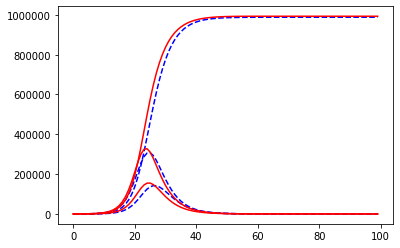

In [12]:
def SEIR(theta, T=100, dE0=10, N=1e6):
    
    SEIR = SEIRModel

    x0 = SEIR.seed(N, 0., dE0)
    X = SEIR.run(T, x0, theta)
    
    labels = ['S', 'E', 'I', 'R', 'CI']

    S = X[:,0]
    E = X[:,1]
    I = X[:,2]
    R = X[:,3]
    C = X[:,4]
    
    return S, E, I, R, C

def Geometric0(mu):
    '''Geometric RV supported on 0,1,...'''
    p = 1/(1+mu)
    log_p = np.log(p)
    log_1_minus_p = np.log(1-p)
    def log_prob(k):
        return np.where(k >= 0, k * log_1_minus_p + log_p, -np.inf)
    return log_prob

def Geometric1(mu):
    '''Geometric RV supported on 1,2,...'''
    p = 1/mu
    log_p = np.log(p)
    log_1_minus_p = np.log(1-p)
    def log_prob(k):
        return np.where(k > 0, (k-1) * log_1_minus_p + log_p, -np.inf)
    return log_prob
    
def SEIR_renewal(theta, T=100, dE0=10, N=1e6, CONV_WIDTH=32):

    beta, sigma, gamma = theta

    # U = latent period
    # V = infectious period
    U_logp = Geometric0(1/sigma)
    V_logp = Geometric1(1/gamma)

    # For some reason this gives closest match to the diff eq. model
    # with U drawn from the geometric distribution supported on non-
    # negative integers and V drawn from the geometric supported on
    # positive integers.
    
    t = np.arange(CONV_WIDTH)
    
    U_pmf = np.exp(U_logp(t))
    U_ccdf = 1 - np.cumsum(U_pmf)

    V_pmf = np.exp(V_logp(t))
    V_ccdf = 1- np.cumsum(V_pmf)
    
    # A(t) = Pr(infectious t time units after being infected) 
    #      = sum_u Pr(U=u) * Pr(V >= t-u)
    #      = convolution of U pmf and V ccdf
    
    A = np.convolve(U_pmf, V_ccdf, mode='full')[:CONV_WIDTH]

    A_rev = A[::-1] # to facilitate convolution incide the dynamics loop
    
    #print("R0", beta*A.sum())
    #print("beta/gamma", beta/gamma)
    
    # Let dE(t) be newly exposed cases at time t. Then
    #
    #  dE(t) = beta * S(t)/N * (# previous cases that are infectious at time t)
    #        = beta * S(t)/N * sum_{s<t} dE(s)*A(t-s)
    #        = beta * S(t)/N * conv(incidence, A)
    #
    def scan_body(state, beta):        
        incidence_history, S = state
        dE = beta * S/N * np.sum(incidence_history * A_rev)
        new_state = (np.append(incidence_history[1:], dE), S-dE)
        return new_state, dE

    incidence_history = np.append(np.zeros(CONV_WIDTH-1), dE0)
    S = N - dE0
    _, dE = jax.lax.scan(scan_body, (incidence_history, S), beta*np.ones(T-1))
    
    dE = np.append(dE0, dE)
    
    # calculate other variables from incident exposures using 
    # various convolutions to "project forward" incident exposures
    E = np.convolve(dE, U_ccdf, mode='full')[:T]
    dI = np.convolve(dE, U_pmf, mode='full')[:T]
    I = np.convolve(dE, A, mode='full')[:T]

    CE = np.cumsum(dE)
    CI = np.cumsum(dI)
    S = N - CE
    
    R = N-S-E-I
    return (S, E, I, R, CI)


R0 = 4.5
gamma = 1.0/2.0
sigma = 1.0/4.0
beta = R0 * gamma
dE0 = 200

theta = (beta, sigma, gamma)

S1, E1, I1, R1, C1 = SEIR(theta, dE0=dE0)
S2, E2, I2, R2, C2 = SEIR_renewal(theta, dE0=dE0, CONV_WIDTH=32)

plt.plot(E1, color='blue', linestyle='--')
plt.plot(I1, color='blue', linestyle='--')
#plt.plot(R1, color='blue', linestyle='--')
plt.plot(C1, color='blue', linestyle='--')

plt.plot(E2, color='red')
plt.plot(I2, color='red')
#plt.plot(R2, color='red')
plt.plot(C2, color='red')

